# Main Pipeline File

the following will be the pipeline:
<ol>
   <li>Read in the files and deal with the missing data. </li>
   <li>Preprocess the signals</li>
   <li>Complete feature extraction</li>
   <li>Put data into a model.</li>
   <li>optimize, compare, iterate - try other models.</li>
</ol>

In [1]:
# Import libraries. 
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt 
import os
import wfdb
import pickle
import sys
import glob
from scipy.signal import butter, lfilter
import pprint


In [2]:
# Load helper files.
import dataloaders
import visualize
import preprocess
import segment 
import cart_model

In [3]:
dataloaders.get_device_info()

Using device: cpu

Using the CPU, no GPU found


In [4]:
file_path = 'C:/Users/henry/OneDrive/Desktop/ELEC 872 - AI and Interactive Systems/Project/mit-bih-arrhythmia-database-1.0.0/'

In [5]:
# Load data. 
patient_data = dataloaders.load_all_records(file_path)

#print(patient_data)
# print(patient_data['102'][0])  # Prints the first beat entry for patient 100

In [6]:
# Load raw ECG and annotations for a single record.
# signal, annotations = dataloaders.load_record(file_path + '/103')
# print(signal.shape)

# record = wfdb.rdrecord(file_path+'/100')  
# test check for loading lead count, weird bug
# print("Number of leads:", record.p_signal.shape[1])


In [7]:
pp = pprint.PrettyPrinter(indent=2)

# Print the structure of the patient_data dictionary
pp.pprint(patient_data['103'][:3])

[ { 'label': 'normal',
    'signal_lead_1': array([-0.375, -0.375, -0.375, -0.375, -0.375, -0.375, -0.375, -0.375,
       -0.385, -0.385, -0.385, -0.38 , -0.36 , -0.36 , -0.37 , -0.365,
       -0.37 , -0.36 , -0.355, -0.345, -0.34 , -0.345, -0.345, -0.33 ,
       -0.325, -0.31 , -0.305, -0.31 , -0.31 , -0.3  , -0.28 , -0.25 ,
       -0.25 , -0.245, -0.235, -0.22 , -0.195, -0.165, -0.16 , -0.16 ,
       -0.135, -0.12 , -0.09 , -0.06 , -0.045, -0.035, -0.015,  0.   ,
        0.03 ,  0.06 ,  0.07 ,  0.075,  0.075,  0.1  ,  0.11 ,  0.135,
        0.13 ,  0.145,  0.135,  0.16 ,  0.165,  0.175,  0.185,  0.175,
        0.165,  0.17 ,  0.16 ,  0.15 ,  0.14 ,  0.12 ,  0.085,  0.08 ,
        0.07 ,  0.055,  0.02 , -0.005, -0.05 , -0.065, -0.085, -0.095,
       -0.125, -0.145, -0.165, -0.175, -0.185, -0.205, -0.215, -0.22 ,
       -0.23 , -0.245, -0.24 , -0.245, -0.245, -0.265, -0.265, -0.265,
       -0.26 , -0.255, -0.27 , -0.265, -0.275, -0.265, -0.275, -0.265,
       -0.27 , -0.265, -0.28 , -0

In [8]:
# Visualize the raw ECG with annotations for the 1 record.
#visualize.visualize_ecg_with_labels(signal, annotations, fs=250, duration=15)
#visualize.visualize_ecg_with_annotationsV2(patient_data, patient_id='221', num_beats=5)

In [9]:
# check for missing values now before preprocessing. 
missing_values_report = preprocess.check_for_missing_values(patient_data)

No missing values found in any patient records.


In [10]:
# # R-R interval calculation. 
# rr_intervals_report = preprocess.calculate_rr_intervals(patient_data, fs=360)
# # print("R-R intervals for patient 100:", rr_intervals_report.get('10', []))

# unique_rr_counts = {patient_id: len(set(rr_intervals)) for patient_id, rr_intervals in rr_intervals_report.items()}
# print(unique_rr_counts)


In [11]:
# # Iterate through each patient in the dataset
# for patient_id, beats in patient_data.items():
#     print(f"Patient ID: {patient_id}")
    
#     # Initialize a counter to track if any non-normal labels are found for the patient
#     non_normal_found = False
    
#     # Iterate through each beat entry for this patient
#     for beat in beats:
#         label = beat['label']
        
#         # Check if label is not "normal"
#         if label == 'atrial_fibrillation':
#             print(f"Label: {label}")
#             non_normal_found = True  # Mark that we found a non-normal label
    
#     # If no non-normal labels found, print a message
#     if not non_normal_found:
#         print("No other labels for this patient.")
    
#     print()  # Separate each patient's output for readability

# Preprocessing Stage

1. High-Pass Filter to remove baseline wander
2. Notch Filter to remove powerline interference (if any?)
3. Low-Pass Filter to remove high-frequency noise (set for 40 hz for now?)
4. Moving Average Filter to smooth the remaining signal 
5. Normalization for 0-->1 because the leads all act differently

<p> may want to consider an FFT or a Wavelet Transform because it's time series data. can determine later on. </p>

In [12]:
# TESTING NEW -1 AND 1 NORMALIZATION, COULDN'T ACCESS EARLY AHAHA

# for patient_id, beats in patient_data.items():
#     for beat in beats:
#         # Apply preprocessing to each lead in the beat entry
#         for key in beat:
#             if key.startswith('signal_lead_'):
#                 beat[key] = preprocess.test_signal(beat[key])

# patient_id = '100'
# if patient_id in patient_data:
#     print("After preprocessing:")
#     pp.pprint(patient_data[patient_id][:3])  # Print first 3 beats for verification
# else:
#     print(f"Patient ID {patient_id} not found in data.")

In [13]:
# Pre-Preprocessing visual check.
#visualize.visualize_ecg_with_annotationsV2(patient_data, patient_id='100', original_fs=360, target_fs=360)

In [14]:
#patient_data = preprocess.apply_filters_and_normalization(patient_data, fs=250)

In [15]:
# Post Pre-Preprocessing visual check.
#visualize.visualize_ecg_with_annotationsV2(patient_data, patient_id='100')
#visualize.visualize_ecg_with_annotationsV2(patient_data, patient_id='221')

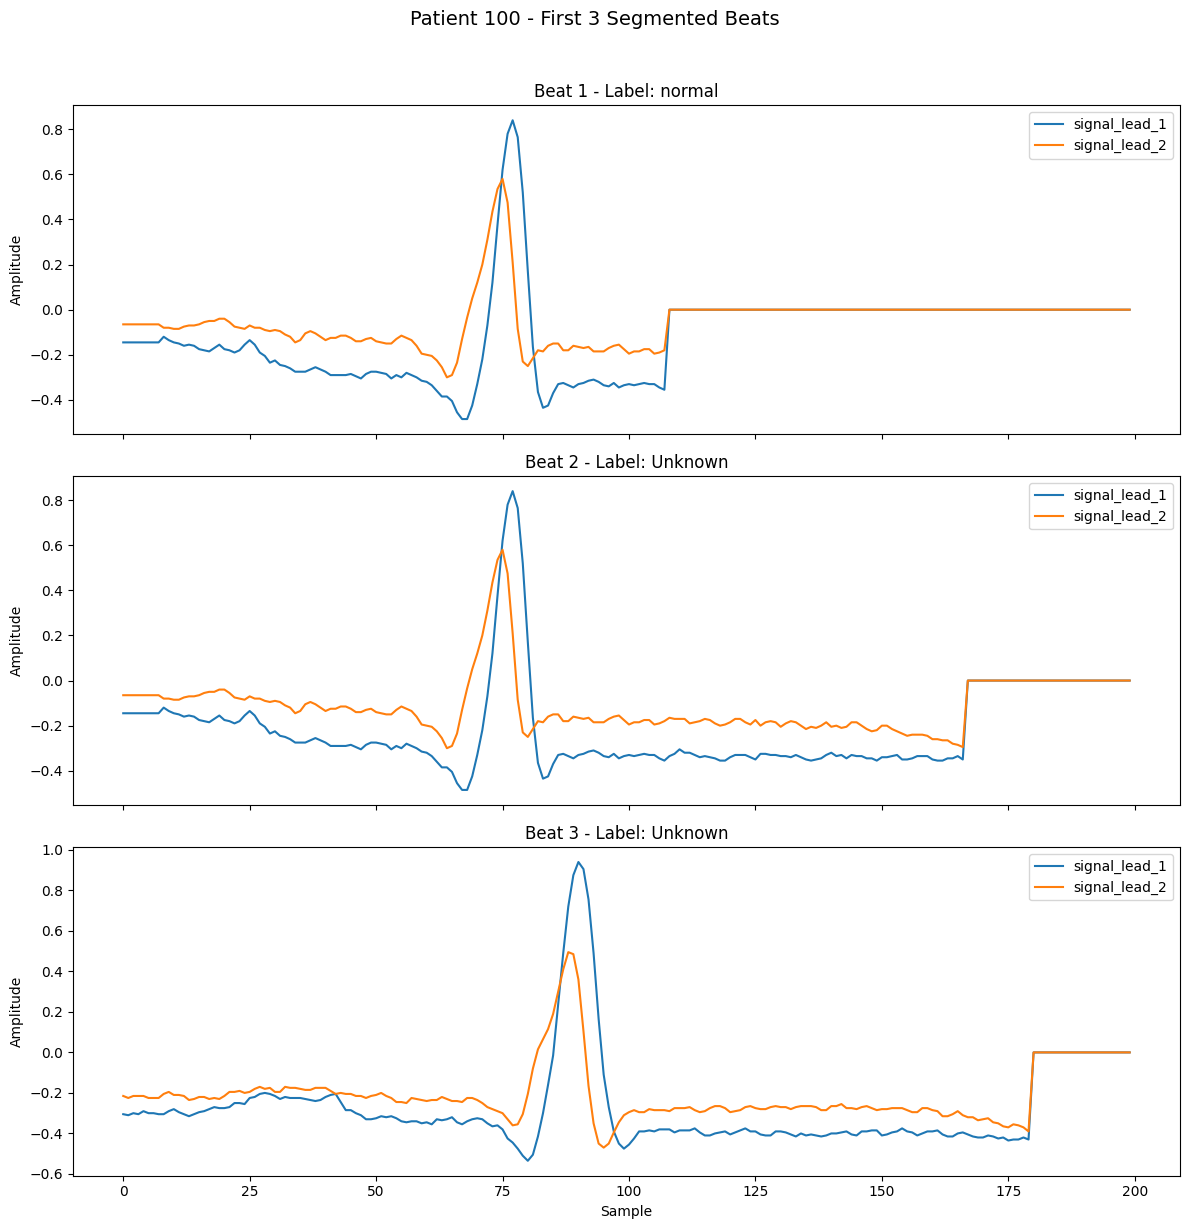

In [16]:
# Segment the data
segmented_data = segment.segment_ecg_data(patient_data, snippet_length=200, samples_before=90, samples_after=90)

# Visualize 
#segment2.visualize_segmented_data(segmented_data, patient_id='100', num_beats=3)
segment.visualize_segmented_data(segmented_data, patient_id='100', num_beats=3)